In [0]:
!pip install soundfile
import os
from scipy.io import wavfile
import numpy as np
import scipy
import scipy.signal
import soundfile as sf
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
from collections import namedtuple
import datetime
import time
from google.colab import drive
import h5py
import cv2
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

# Connect to google drive



In [0]:
drive.mount('/content/drive')
os.chdir('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Get the labels <br>
Low and highFrequencies are in col 5 and 6. <br>
File path is in col 7. <br>
Split the file to get the start time of the cur recording. <br>
Begin clock time is in col 10. <br>
Use the start and end clock time (in col 3,4) adding to the begin clock time to decide the time period. <br>
Sonotype is in col 11.


In [0]:
# all the sound files
labelDir = "Shared drives/Stethoscope for the rainforests/Training data set /"
labelFiles = ["Table_control_May5_2020.txt", "Table_13AB_May5_2020.txt"]

times = [] 
freqs = []
files = []
sonotypes = []
actTimes = []
groups = []

for labelFile in labelFiles:
  labelFilePath = labelDir + labelFile
  with open(labelFilePath) as file:
    label_reader = csv.reader(file, delimiter='\t')
    for row in label_reader:
      # not use the first row
      if (not row[0].isnumeric()):
        continue

      # all the recording are either start at 0min or 30mins
      duration = float(row[4]) - float(row[3])
      timeWeight = [3600,60,1]
      actSta = sum([a*b for a,b in zip(timeWeight, map(int,row[10].replace('.',":").split(':')[:3]))])
      actEnd = actSta + duration
      
      # get the start time of cur recording
      fileName = row[7].split("\\")[-1]
      # 3B_20180607_070500_Dawn_Sunrise_Based.wav
      # or 20180908_060000_13A_24H [1.4452 116.9811].wav
      splName = fileName.split("_")

      # actual time is either in index 1 or 2 in splName
      if (len(splName[1]) == 6):
        strTime = splName[1]         
      elif (len(splName[2]) == 6):   
        strTime = splName[2]
      else: 
        print(row[0])
        continue  

      recLis = [int(strTime[0]) * 10 + int(strTime[1]),
                int(strTime[2]) * 10 + int(strTime[3]), 
                int(strTime[4]) * 10 + int(strTime[5])]    

      recSta = sum([a*b for a,b in zip(timeWeight, recLis)])

      # start, end time used to corp the specs
      start = actSta - recSta
      end = start + duration

      try:
        sonotypes.append(int(row[11]))
        times.append([start,end])
        actTimes.append([actSta, actEnd])
        freqs.append([float(row[5]), float(row[6])])
        files.append(fileName) 
        groups.append(row[12])
      except:
        # selection number
        print(row[0])
        pass

print("dataset size:  %i" % len(times))    
print("filename sample: " + files[0])

print(files[len(files)-1])
print(actTimes[len(files)-1])
print(times[len(files)-1])

dataset size:  2881
filename sample: 20180710_060000_5A_F24H [1.4552 117.0019].wav
20190406_090000_13A_24H [1.4438 116.9805].wav
[34110, 34142.25009616895]
[1710, 1742.2500961689511]


#Creat H5 data storage


In [0]:
# f.close()
f = h5py.File('My Drive/Stethoscope/whole_data_latest.hdf5', 'w')

data = f.create_dataset("specs", (0,224,224,3,), maxshape=(None,None,None,None,), chunks=True)
data = f.create_dataset("sonotypes", (0,),  maxshape=(None,), chunks=True)
data = f.create_dataset("times", (0,2,), maxshape=(None,None,), chunks=True)
data = f.create_dataset("freqs", (0,2,), maxshape=(None,None,), chunks=True)
data = f.create_dataset("groups", (0,),  maxshape=(None,), chunks=True, dtype="S10")

f.close()

In [0]:
a=np.array([[1,2],[1,2],[1,2],[1,2],[1,2],[1,2],[1,2]])

a[:3,:].fill(0)
a[4:,:].fill(0)
a

array([[0, 0],
       [0, 0],
       [0, 0],
       [1, 2],
       [0, 0],
       [0, 0],
       [0, 0]])

# Get the data according to the labels and store into database


In [0]:
# all the sound files
fileDirPath = "Shared drives/Stethoscope for the rainforests/Sound data/EastKalimantan/"
fileDirNames = ["13AB/", "Control sites/"]

for fileDirName in fileDirNames:
  fileDir = fileDirPath + fileDirName
  soundFiles = os.listdir(fileDir)
  usedFiles = np.intersect1d(soundFiles, files)

  for curFile in usedFiles:
    print("processing " + curFile)
    filePath = fileDir + curFile
    audio, rate = sf.read(filePath)

    # used to store info after resizing the image
    specs_resized = []
    freqs_updated = []
    times_updated = []
    sonotypes_updated = []
    groups_updated = []

    # plot the spectrogram
    freq, t, spec = scipy.signal.spectrogram(audio, rate)
    for i in range(len(files)):
      if(files[i] == curFile):
        boxTime = times[i]
        boxFreq = freqs[i]

        # get low and high freq index of the box
        low_freq = np.argmin(np.abs(freq - boxFreq[0]))
        high_freq = np.argmin(np.abs(freq - boxFreq[1]))
        # get start and end time of the box
        start = np.argmin(np.abs(t - boxTime[0]))
        end = np.argmin(np.abs(t - boxTime[1]))

        # adjust the params to cover the whole box
        # be aware of index out of bound
        if freq[low_freq] > boxFreq[0]: 
          low_freq = max(low_freq -1,0)

        if freq[high_freq] < boxFreq[1]: 
          high_freq = high_freq + 1

        if t[start] > boxTime[0]: 
          start = max(start - 1, 0)

        if t[end] < boxTime[1]: 
          start = start + 1

        # specs[i] = spec[low_freq:high_freq, start:end]
        # cur_spec = spec[low_freq:high_freq, start:end]
        cur_spec = spec
        cur_spec[:low_freq,:].fill(0)
        cur_spec[high_freq:,:].fill(0)
  
        # boxFreqPlt = freq[low_freq: high_freq]
        # boxTPlt = t[start:end]

        if cur_spec.size != 0:
          # resize
          spec_resized=cv2.resize(cur_spec,(224,224))
          spec_resized=cv2.cvtColor(spec_resized.astype('float32'), cv2.COLOR_BGR2RGB) #cv2 does not accept float64 
          spec_resized = np.flip(spec_resized,0)
          
          # normalization
          # s_min = np.amin(spec_resized)
          # s_max = np.amax(spec_resized)
          # spec_resized = (spec_resized - s_min)/(s_max - s_min) * 255
          # use threshold to get rid of small data
          # threshold = np.percentile(spec_resized, 80)
          threshold = np.percentile(spec[low_freq:high_freq, start:end], 80)
          spec_resized = np.where(spec_resized < threshold, 0, 255)

          specs_resized.append(spec_resized)
          freqs_updated.append(freqs[i])
          times_updated.append(actTimes[i])
          sonotypes_updated.append(sonotypes[i])
          groups_updated.append(groups[i])  

    # print("data in current file: %i" % len(times_updated))
    
    # store to H5 data storage
    f =  h5py.File('My Drive/Stethoscope/whole_data_latest.hdf5', "a")
    f["times"].resize((f["times"].shape[0] + len(times_updated)), axis = 0)
    f["times"][-len(times_updated):,:] = times_updated

    f["freqs"].resize((f["freqs"].shape[0] +  len(times_updated)), axis = 0)
    f["freqs"][-len(times_updated):,:] = freqs_updated

    f["specs"].resize((f["specs"].shape[0] +  len(times_updated)), axis = 0)
    f["specs"][-len(times_updated):,:,:,:] = specs_resized

    f["sonotypes"].resize((f["sonotypes"].shape[0] + len(times_updated)), axis = 0)
    f["sonotypes"][-len(times_updated):] = np.array(sonotypes_updated)

    f["groups"].resize((f["groups"].shape[0] + len(times_updated)), axis = 0)
    f["groups"][-len(times_updated):] = np.array(groups_updated, dtype="S")

    f.close()


processing 20180607_060400_Dawn_Sunrise____13B_.4455 116.9813].wav
processing 20180607_120400_Midday_Sunrise___13B_.4455 116.9813].wav
processing 20180607_174600_Dusk___13B_ [1.4455 116.9813].wav
processing 20180710_060000_13A_24H [1.4452 116.9811].wav
processing 20180710_093000_13A_24H [1.4452 116.9811].wav
processing 20180710_100000_13A_24H [1.4452 116.9811].wav
processing 20180710_180000_13A_24H [1.4452 116.9811].wav
processing 20180809_060000_13A_24H [1.4452 116.9811].wav
processing 20180809_120000_13A_24H [1.4452 116.9811].wav
processing 20180809_180000_13A_24H [1.4452 116.9811].wav
processing 20180908_060000_13A_24H [1.4452 116.9811].wav
processing 20180908_103000_13A_24H [1.4452 116.9811].wav
processing 20180908_110000_13A_24H [1.4452 116.9811].wav
processing 20180908_120000_13A_24H [1.4452 116.9811].wav
processing 20180908_170000_13A_24H [1.4452 116.9811].wav
processing 20180908_173000_13A_24H [1.4452 116.9811].wav
processing 20180908_180000_13A_24H [1.4452 116.9811].wav
proces

# **Misc**

## tests and others

In [0]:
# check hdf5 file
f =  h5py.File('My Drive/Stethoscope/13A_data_wi.hdf5', "r+")
specs = np.array(f["specs"]).astype("float32")
sonotypes = np.array(f["sonotypes"]).astype("float32")
times = np.array(f["times"]).astype("float32")
freqs = np.array(f["freqs"]).astype("float32")
sonotypes_h5 = np.array(f["groups"])
f.close()

print(specs.shape)
print(sonotypes.shape)
print(freqs.shape)
print(times.shape)
print(groups[10])

In [0]:
print(freqs[10])

[1653.8 1981.9]


In [0]:
plt.imshow(x_train[100][:,:,2])
plt.show()
print(y_train[100])

NameError: ignored

Resize spectrograms to 224 * 224 * 3, test whether look the same to the original spectrogram.

spec number: 502
sonotype: 68
filename: 20181008_173000_13A_24H [1.4452 116.9811].wav


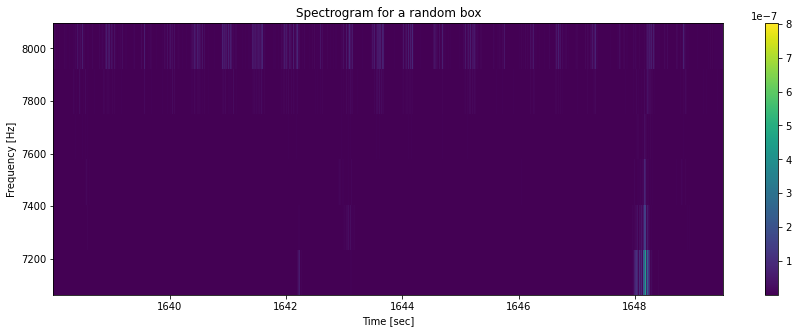

In [0]:
index = random.randint(0, len(specs_resized) - 1)
print("spec number: %d" % index)
print("sonotype: %d" % sonotypes_updated[index])
print("filename: %s" % files[index])

# compute the data for the spectrogram
ranFile = files[index]
fileDir = "Shared drives/Stethoscope for the rainforests/Sound data/EastKalimantan/13A/"
ranFilePath = fileDir + curFile
audio, rate = sf.read(ranFilePath)
freq, t, spec = scipy.signal.spectrogram(audio, rate)

# get low and high freq index of the box
boxTime = times_updated[index]
boxFreq = freqs_updated[index]

# get low and high freq index of the box
low_freq = np.argmin(np.abs(freq - boxFreq[0]))
high_freq = np.argmin(np.abs(freq - boxFreq[1]))
# get start and end time of the box
start = np.argmin(np.abs(t - boxTime[0]))
end = np.argmin(np.abs(t - boxTime[1]))

# adjust the params to cover the whole box
if freq[low_freq] > boxFreq[0]: 
  low_freq = low_freq -1

if freq[high_freq] < boxFreq[1]: 
  high_freq = high_freq + 1

if t[start] > boxTime[0]: 
  start = start - 1

if t[end] < boxTime[1]: 
  start = start + 1

boxSpecPlt = spec[low_freq:high_freq, start:end]
boxFreqPlt = freq[low_freq: high_freq]
boxTPlt = t[start:end]

# plot the spectrogram
# set up
plt.figure(figsize=(15, 5))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram for a random box")

# plot
plt.pcolormesh(boxTPlt, boxFreqPlt, boxSpecPlt)
plt.colorbar()

(224, 224, 3)


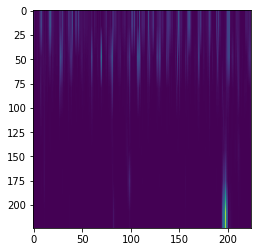

In [0]:
# file = specs_resized[index]
spec_resized=cv2.resize(boxSpecPlt,(224,224))
spec_resized=cv2.cvtColor(spec_resized.astype('float32'), cv2.COLOR_BGR2RGB) #cv2 does not accept float64   
spec_resized= np.flip(spec_resized,0)

print(spec_resized.shape)
plt.imshow(spec_resized[:,:,1])
plt.show()

Resize the data

In [0]:
specs_resized = []
# for some sound not found
freqs_updated = []
times_updated = []
sonotypes_updated = []

empty_specs = []
for i in range(len(files)):
  if specs[i].size:
    spec_resized=cv2.resize(specs[i],(224,224))
    spec_resized=cv2.cvtColor(spec_resized.astype('float32'), cv2.COLOR_BGR2RGB) #cv2 does not accept float64   
    specs_resized.append(np.flip(spec_resized,0))
    freqs_updated.append(freqs[i])
    times_updated.append(actTimes[i])
    sonotypes_updated.append(sonotypes[i])
  else:
    empty_specs.append(i)
  
print(empty_specs)
print(specs_resized[0].shape)

[]
(224, 224, 3)


Seperate Trainning and Testing dataset.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(specs_resized, sonotypes_updated, test_size=0.1, random_state = 42)

print(len(x_train))
print(len(x_test))

1320
147


 Store data to H5 data storage 

In [0]:
f = h5py.File('My Drive/Stethoscope/13A_data.hdf5', 'w')

data = f.create_dataset("specs", data = np.array(specs_resized))
data = f.create_dataset("sonotypes", data = np.array(sonotypes_updated))
# data = f.create_dataset("y_train", data = np.array(y_train))
# data = f.create_dataset("y_test", data = np.array(y_test))

data = f.create_dataset("times", data = np.array(times_updated))
data = f.create_dataset("freqs", data = np.array(freqs_updated))

f.close()

In [0]:
f = h5py.File('My Drive/Stethoscope/13A_data.hdf5', 'a')

# data = f.create_dataset("times", data = np.array(actTimes))
# data = f.create_dataset("freqs", data = np.array(freqs))
data = f.create_dataset("times", data = np.array(times_updated))
data = f.create_dataset("freqs", data = np.array(freqs_updated))

f.close()

Test whether the boxes are interpreted correctly

In [0]:
pltFile = usedFiles[0]
filePath = fileDir + pltFile
audio, rate = sf.read(filePath)

# set up
plt.figure(figsize=(30, 10))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram of the wav file: " + pltFile)

# plot spectrogram
freq, t, spec = scipy.signal.spectrogram(audio, rate)
plt.pcolormesh(t, freq, spec)
# plt.pcolormesh(wholeT, wholeFreq, wholeSpec)

# Create Rectangle patches
for i in range(len(times)):
   if(files[i] == pltFile):
      boxTime = times[i]
      boxFreq = freqs[i]

      # get low and high freq index of the box
      low_freq = np.argmin(np.abs(freq - boxFreq[0]))
      high_freq = np.argmin(np.abs(freq - boxFreq[1]))
      # get start and end time of the box
      start = np.argmin(np.abs(t - boxTime[0]))
      end = np.argmin(np.abs(t - boxTime[1]))

      # adjust the params to cover the whole box
      if freq[low_freq] > boxFreq[0]: 
        low_freq = low_freq -1

      if freq[high_freq] < boxFreq[1]: 
        high_freq = high_freq + 1

      if t[start] > boxTime[0]: 
        start = start - 1

      if t[end] < boxTime[1]: 
        start = start + 1
          
      ymin = freq[low_freq]/freq[len(freq) -1]
      ymax = freq[high_freq]/freq[len(freq) -1]
      xmin = t[start]
      xmax = t[end]
      plt.axvspan(xmin, xmax, ymin=ymin, ymax=ymax, fill = False)